<a href="https://www.kaggle.com/code/eleonoraricci/spell-check-on-tick-labels-using-bert?scriptVersionId=128622574" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Leveraging a pre-trained Language Model to correct tick label predictions**

The **[Making Graphs Accessible](https://www.kaggle.com/competitions/benetech-making-graphs-accessible)** challenge is a very interesting puzzle 🧩 in which several pieces must come together to get to the endgame, and as such it allows to tie together machine learning techniques and methods pertaining to multiple modalities! 🖺🖊️🖼️📊📈

In this notebook I want to share an idea on how one could **improve the predictions for the tick labels** in the graphs, obtained for example by an OCR network, by **using a pretrained Language Model (LM)**, such as BERT. **BERT** (Bidirectional Encoder Representations from Transformers) is a pre-trained language model, based on the Transformer architecture, with context awareness. I am leaving some resources at the end of the notebook for anyone interested in knowing more.

*&rarr;&rarr; you can check out [this interesting notebook](https://www.kaggle.com/code/alejopaullier/benetech-simple-ocr-network) for more details on a simple OCR implementation!*.  

Let's dive in! 🌊

# **Sample image x-axis tick labels**
For starters, let's load a sample image from the training set and print out the corresponding annotations. Let's consider for example the x-axis tick labels. The corresponding predictions for the x-axis tick labels will be the target that we'll try to improve with the pre-trained Language Model.


 x-axis annotations:  ['Slovenia', 'South Africa', 'South America', 'South Korea', 'South Sudan', 'Spain', 'Sri Lanka', 'Sudan', 'Suriname', 'Sweden', 'Switzerland', 'Syria', 'Taiwan', 'Tajikistan', 'Tanzania'] 



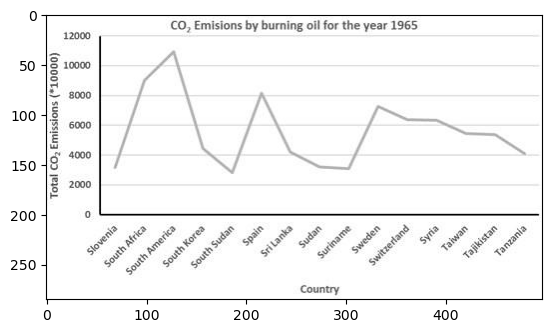

In [1]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

sample_image = "/kaggle/input/benetech-making-graphs-accessible/train/images/00c73795f795.jpg"
image = cv2.imread(sample_image)
sample_annotation = "/kaggle/input/benetech-making-graphs-accessible/train/annotations/00c73795f795.json"

with open(sample_annotation) as f:
    annotation = json.loads(f.read())
    
plt.imshow(image)    

x_axis_annotations = [annotation["data-series"][i]['x'] for i in range(len(annotation["data-series"]))]
print("\n", "x-axis annotations: ", x_axis_annotations, "\n")

# **Predict the tick labels using an OCR Network**

By feeding our image to an OCR (**Object Character Recognition**) network we get as an output not only the **text** recognized by the model, but also the various **boxes** bounds and the **confidence scores** associated to the predictions. We could make the life of the OCR easier, by separating the task of recognizing the boxes, using an Object Detection network in front of the OCR, but here I wanted to focus on the postprocesing of the predictions, so I kept this step as simple as possible.  


In [2]:
import easyocr
import pandas as pd

reader = easyocr.Reader(['en']) 
ocr_predictions = reader.readtext(image) 

# Uncomment the following line to see the whole OCR output
# pprint(ocr_predictions) 

# Here I only extract the text and the confidence
df = pd.DataFrame([[ocr_predictions[i][1],ocr_predictions[i][2]]  for i in range(len(ocr_predictions))], 
                    columns=["Text predicted", "Confidence"])
df.sort_values(by=["Confidence"], ascending=False)


,Text predicted,Confidence
15,South Sudan,0.995395
21,Surina,0.973984
11,Country,0.973616
14,America,0.939632
10,2000,0.938489
0,Emisions by burning oil for the vear 1965,0.920999
7,4000,0.906883
20,South Kor,0.861083
12,Slavenia,0.839528
16,1,0.803970


As we can see the accuracy in the tick label predictions is not that great, and the confidence is also rather low for several of them. 

So let's see if we can improve this with the help of a spell checker model! 🚀

I tried **NeuSpell** ([GitHub link](https://github.com/neuspell/neuspell)), which supports the use of multiple LM models, including BERT.

# **Get the Spell Checker up and running** 📎✔️

### **Install neuspell**

In [3]:
!git lfs install
!git clone https://huggingface.co/pszemraj/neuspell-subwordbert-probwordnoise

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
Cloning into 'neuspell-subwordbert-probwordnoise'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), 5.36 KiB | 548.00 KiB/s, done.
Filtering content: 100% (3/3), 2.75 GiB | 26.17 MiB/s, done.


In [4]:
!pip install -U neuspell -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.4.2 requires botocore<1.27.60,>=1.27.59, but you have botocore 1.29.129 which is incompatible.


### **Import and download the pre-trained model**

In [5]:
from neuspell import BertChecker
checker = BertChecker()
checker.from_pretrained("./neuspell-subwordbert-probwordnoise/")

data folder is set to `/opt/conda/lib/python3.7/site-packages/neuspell/../data` script


loading vocab from path:./neuspell-subwordbert-probwordnoise/vocab.pkl
initializing model


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SubwordBert(
  (bert_dropout): Dropout(p=0.2, inplace=False)
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): 

# **Call the spell checker!**

Let's feed the spell checker the list of faulty labels predicted by the OCR, to see if there is any improvement. 


*NOTE: for the sake of simplicity here I selected the range of OCR predictions related to the x-axis lables manually (11-24) but of course this step would need to be automated*

In [6]:
before_spell_check = [ocr_predictions[i][1]  for i in range(11,24)]
print("Before spell check: ", before_spell_check)

# Call che spell checker
after_spell_check = checker.correct_strings([ocr_predictions[i][1] for i in range(11,24)])
print(" After spell check: ", after_spell_check)

Before spell check:  ['Country', 'Slavenia', '1 Atrica', ' America', 'South Sudan', '1', 'Sti Lanka', 'Tatwan', 'Tajkistan', 'South Kor', 'Surina', '~South', 'South /']
 After spell check:  ['Country', 'Slovenia', '1 Africa', 'American', 'South Sudan', '1', 'Sri Lanka', 'Taiwan', 'Tajikistan', 'South Korea', 'Surina', '~ South', 'South /']


# **Final result**

Indeed **BERT corrected several things**:
* Slavenia &rarr; Slovenia 
* Atrica &rarr; Africa
* Sti Lanka &rarr; Sri Lanka
* Tatwan &rarr; Taiwan
* Tajkistan &rarr; Tajikistan
* South Kor &rarr; South Korea

There is still plenty of work to be done, for example it could be helpful to perform some clean-up to **remove spurious characters** such as "~", "/", and "1", but overall I thought it was an interesting angle worth sharing.

I hope you found this useful, and any feedback or question you may have is more than welcome! 🧐


### **BERT resources**
1. The [original BERT paper](https://arxiv.org/pdf/1810.04805.pdf&usg=ALkJrhhzxlCL6yTht2BRmH9atgvKFxHsxQ): "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding" by Jacob Devlin et al. 
2. The [BERT GitHub repository](https://github.com/google-research/bert): it contains the code for pre-training and fine-tuning BERT, as well as many pre-trained models and examples of how to use them.
3. The [BERT Explained series by Jay Alammar](https://jalammar.github.io/illustrated-bert/): if you are not familiar with his work, definitely check out any of the blog posts and videos that he has made on a variety of ML methods and architectures.